In [1]:
import espressomd.shapes
from espressomd import polymer
from espressomd.interactions import FeneBond
from espressomd.interactions import AngleCosine
import numpy as np
import matplotlib.pyplot as plt
from espressomd.observables import ParticlePositions
from espressomd.observables import ComPosition
from espressomd.accumulators import Correlator
from espressomd.observables import DensityProfile
from pprint import pprint
from threading import Thread
#from espressomd import visualization
import sys
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [2]:
#system setup
sys_boxl = [20.,20.,100.]
sys_dt_start = 0.001 
sys_temperature_start = 0.2 
sys_gamma = 1.0 

system = espressomd.System(box_l = sys_boxl)
system.time_step = sys_dt_start
system.thermostat.set_langevin(kT = sys_temperature_start,
                              gamma = sys_gamma,
                              seed=40)

In [3]:
#define cavity:
pore = espressomd.shapes.SimplePore(axis=[0., 0., 1.],
                  length=12.,
                  radius=3.,
                  smoothing_radius=1.,
                  center=[10., 10., 0.])
constrt = espressomd.constraints.ShapeBasedConstraint(shape = pore, penetrable=False)
system.constraints.add(constrt)

wall = espressomd.shapes.Wall(dist=0, normal=[0., 0., 1.])
wall2 = espressomd.shapes.Wall(dist=-100., normal=[0., 0., -1.])

constrt2 = espressomd.constraints.ShapeBasedConstraint(shape = wall, penetrable=False)
system.constraints.add(constrt2)
constrt3 = espressomd.constraints.ShapeBasedConstraint(shape = wall2, penetrable=False)
system.constraints.add(constrt3)

In [4]:
#initialize polymer
N_MONOMER = 150 
BOND_L = 0.3 
n_polymers = 1

z_pos = np.arange(40+0.5,N_MONOMER+1+0.5,BOND_L)
x_pos = sys_boxl[0]*0.5*np.ones(N_MONOMER)
y_pos = sys_boxl[1]*0.5*np.ones(N_MONOMER)

for j in range(n_polymers):
    for i in range(N_MONOMER):
        system.part.add(type=j+1,pos=[x_pos[i],y_pos[i], z_pos[i]+j*N_MONOMER*BOND_L],q=-1.)

In [16]:
#for particle in system.part:
    
    #print(particle.pos)

In [5]:
wca_epsilon = 1. 
wca_sigma = 0.3 

system.non_bonded_inter[0,1].wca.set_params(epsilon=20, #*20
                                           sigma=0.2) #-0.2
system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                           sigma=wca_sigma)

fene_k = 10.
fene_drmax = 2.
fene_r0 = 0.0

# fene bonds
fene = FeneBond(k=fene_k, d_r_max=fene_drmax, r_0=fene_r0)
system.bonded_inter.add(fene)

previous_particle = None
for particle in system.part:
    #print("Position:", particle.pos)
    if previous_particle is not None and particle != previous_particle:
        particle.add_bond((fene, previous_particle))
    previous_particle = particle

In [6]:
#warming up
system.cell_system.skin = 0.3
warm_steps = 5 # control the force release rate. smaller, faster. Break bond: relase too fast. 
# Constrt violated: too slow.
warm_n_time = 2000 # 
min_dist = 10
wca_cap = 1.0
i = 0
while i<warm_n_time:
    system.force_cap = wca_cap
    system.integrator.run(warm_steps)

    wca_cap += 0.5 
    i+=1
    if i%200==0:
        print(i)

    if i==600:
        wca_sigma = 0.4 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

        angle_cosine = AngleCosine(bend=0.48, phi0=np.pi) 
        system.bonded_inter.add(angle_cosine)

        #for j1 in range(n_polymers):
            #for i1 in range(N_MONOMER-2):
                #system.part[int(N_MONOMER*j1+i1+1)].add_bond((angle_cosine, int(N_MONOMER*j1+i1), int(N_MONOMER*j1+i1+2)))

    if i==800:
        wca_sigma = 0.5 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)
    if i==1000:
        wca_sigma = 0.6 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

    if i==1200:
        wca_sigma = 0.7 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

    if i==1400:
        wca_sigma = 0.8 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)

    if i==1600:
        wca_sigma = 0.9 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)
        
    if i==1800:
        wca_sigma = 1.0 
        system.non_bonded_inter[1,1].wca.set_params(epsilon=wca_epsilon, 
                                                   sigma=wca_sigma)
        
system.force_cap = 0
print('Warming done!')

200
400
600
800
1000
1200
1400
1600
1800
2000
Warming done!


## Homogeneous pressure field

In [ ]:
#visualize
intstep = 2000
skip = 50

sys_dt = 0.005
system.time_step = sys_dt
sys_temperature = 0.2
system.thermostat.set_langevin(kT = sys_temperature,
                              gamma = sys_gamma,
                              seed=20)
def main():
    for i in range(intstep):
        #print(p)
        system.integrator.run(200)
        if i % skip == skip - 1:
            positions = []
            for particle in system.part:
                positions.append(particle.pos)
            positions = np.asarray(positions)

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2])
            plt.show()
            print(f"Iteration {i}")

        if i == 1000:
            field = espressomd.constraints.HomogeneousFlowField(gamma=1, u=[0, 0, -0.5])
            system.constraints.add(field)

system.time = 0
t = Thread(target=main)
t.daemon = True
t.start()

## Electric field

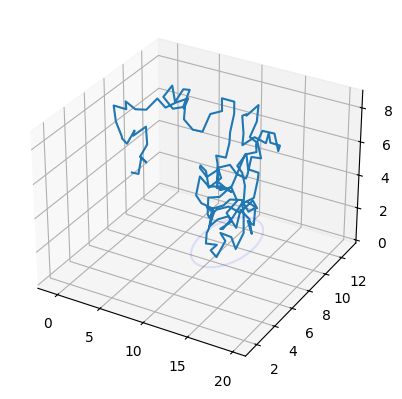

Iteration 49


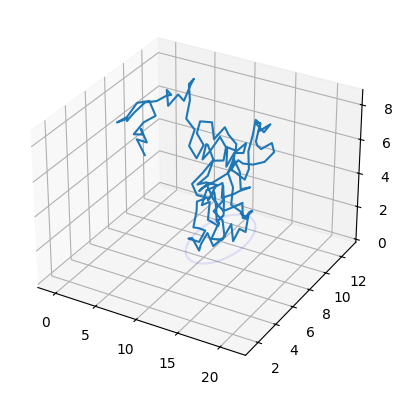

Iteration 99


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "/usr/local/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_59/892746048.py", line 23, in main
  File "integrate.pyx", line 83, in espressomd.integrate.IntegratorHandle.run
  File "integrate.pyx", line 225, in espressomd.integrate.Integrator.run
  File "utils.pyx", line 258, in espressomd.utils.handle_errors
  File "utils.pyx", line 277, in espressomd.utils.handle_errors
Exception: Encountered errors during integrate: ERROR: bond broken between particles 110, 109


In [8]:
#visualize
intstep = 2000
skip = 50

sys_dt = 0.005
system.time_step = sys_dt
sys_temperature = 0.2
system.thermostat.set_langevin(kT = sys_temperature, gamma = sys_gamma, seed=20)

# circle params
radius = 3
center = [10., 10., 0.]
theta = np.linspace(0, 2*np.pi, 100)
x_circle = center[0] + radius * np.cos(theta)
y_circle = center[1] + radius * np.sin(theta)
z_circle = center[2] * np.ones_like(theta)


def main():
    for i in range(intstep):
        #print(p)
        system.integrator.run(200)
        if i % skip == skip - 1:
            positions = []
            for particle in system.part:
                positions.append(particle.pos)
            positions = np.asarray(positions)

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2])
            ax.plot(x_circle, y_circle, z_circle, color='blue', alpha=0.1)
            plt.show()
            print(f"Iteration {i}")

        if i == 1000:
            electric_field_strength = [0, 0, 0.1]
            linear_electric_potential = espressomd.constraints.LinearElectricPotential(E=electric_field_strength, phi=0)
            system.constraints.add(linear_electric_potential)

system.time = 0
t = Thread(target=main)
t.daemon = True
t.start()

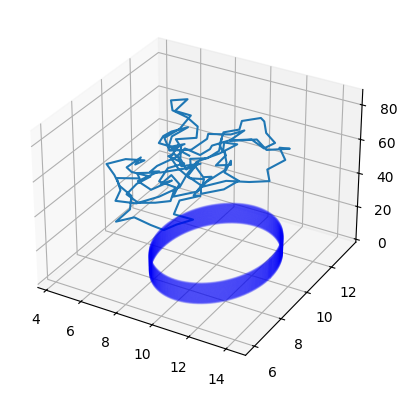

Iteration 49


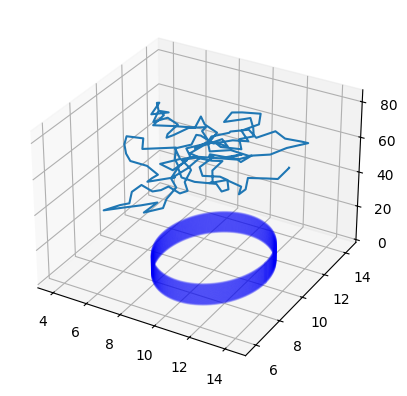

Iteration 99


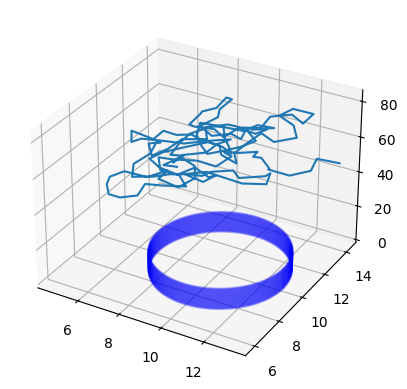

Iteration 149


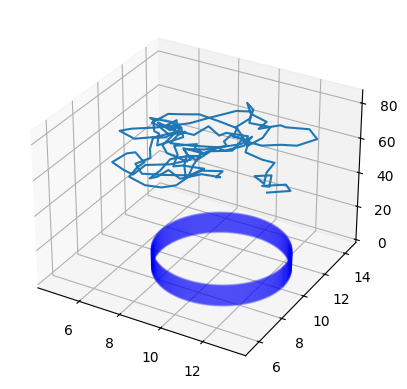

Iteration 199


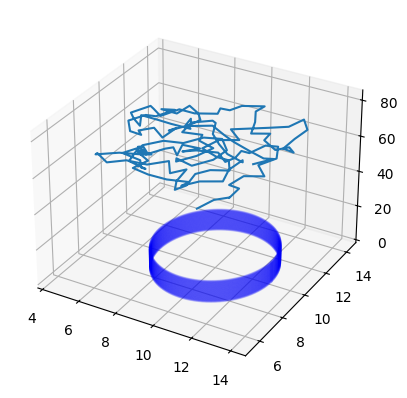

Iteration 249


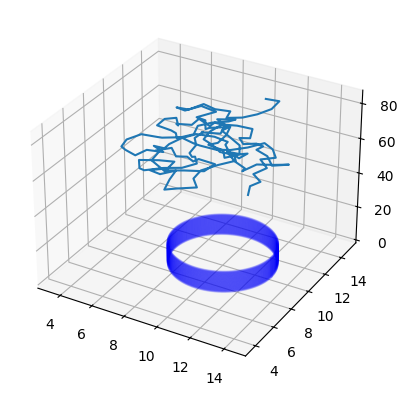

Iteration 299


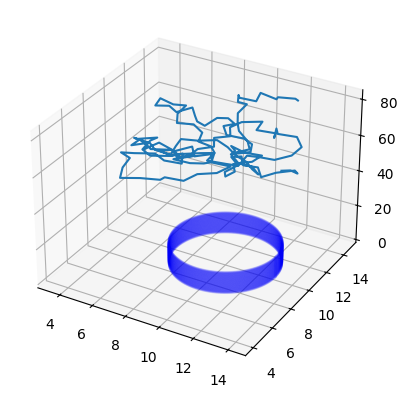

Iteration 349


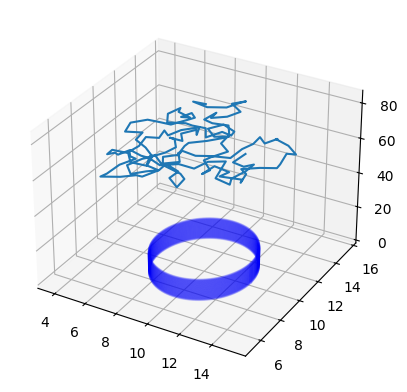

Iteration 399


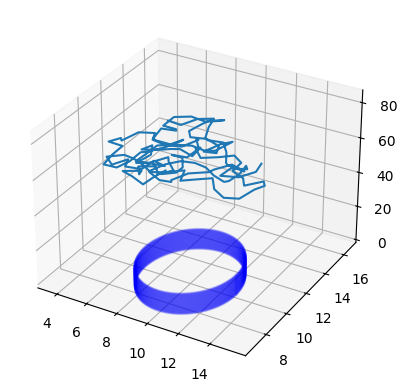

Iteration 449


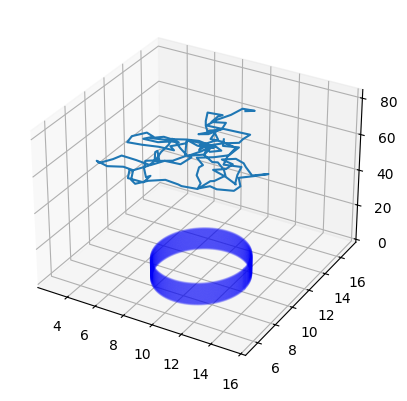

Iteration 499


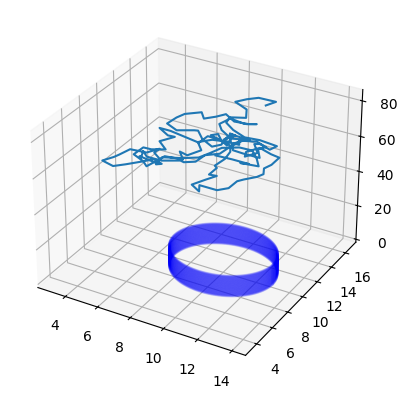

Iteration 549


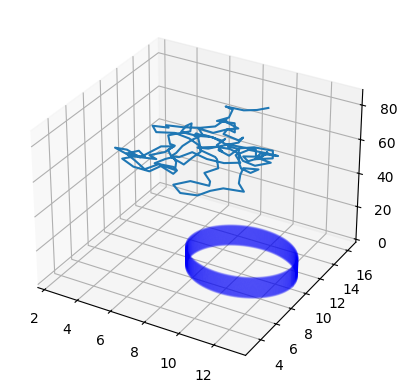

Iteration 599


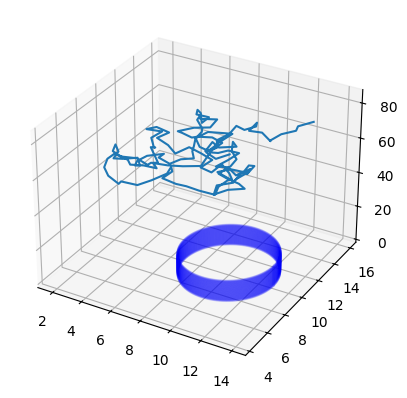

Iteration 649


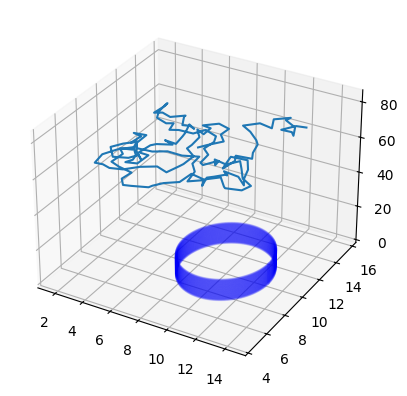

Iteration 699


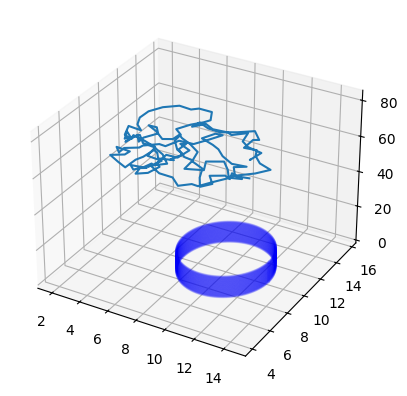

Iteration 749


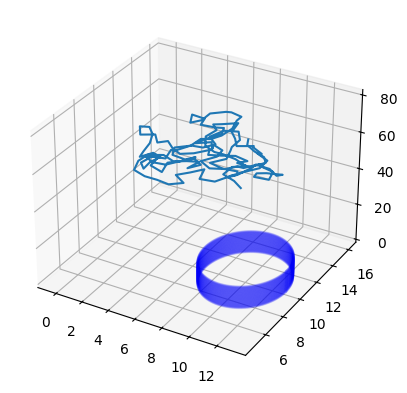

Iteration 799


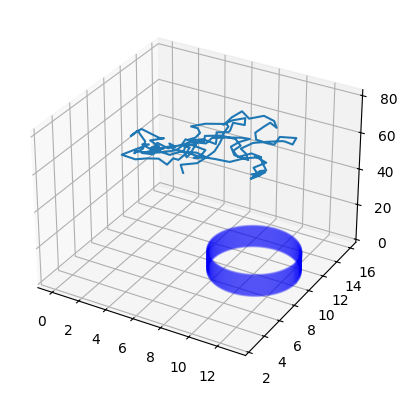

Iteration 849


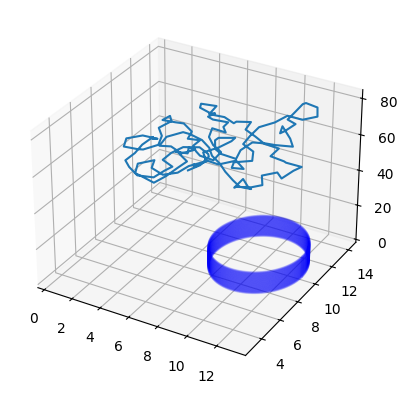

Iteration 899


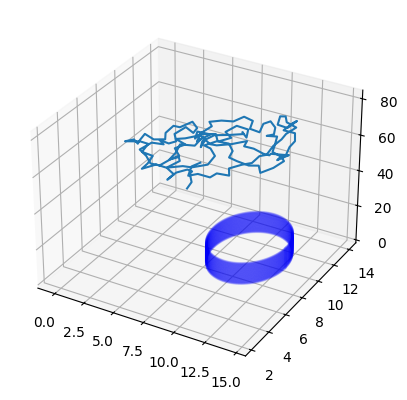

Iteration 949


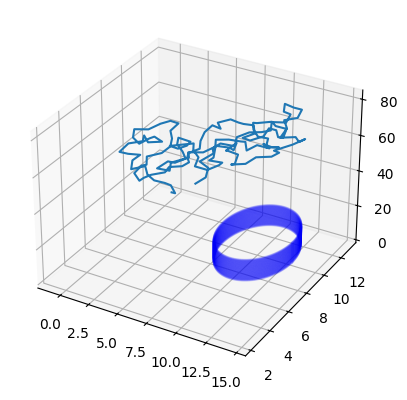

Iteration 999


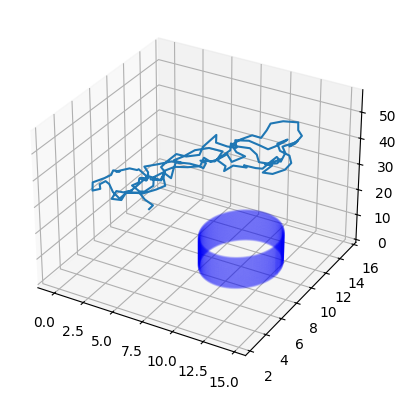

Iteration 1049


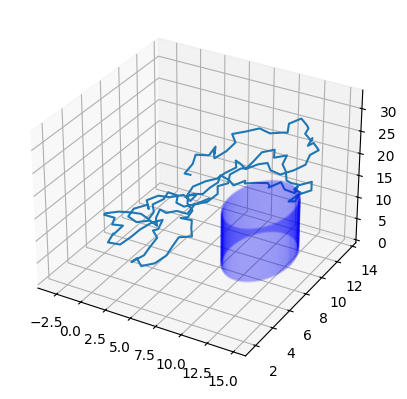

Iteration 1099


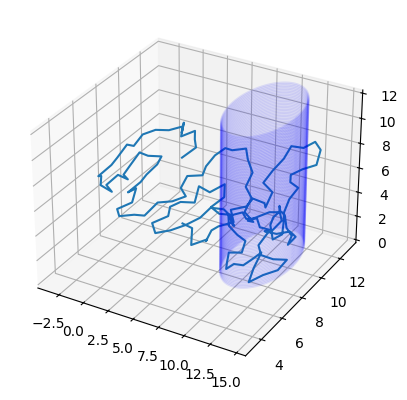

Iteration 1149


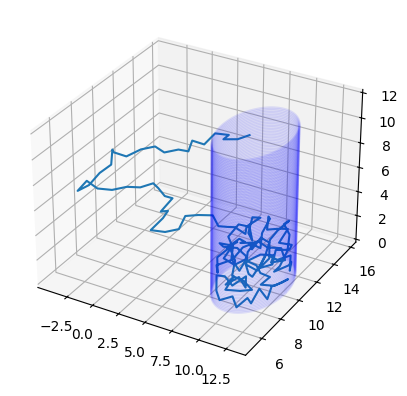

Iteration 1199


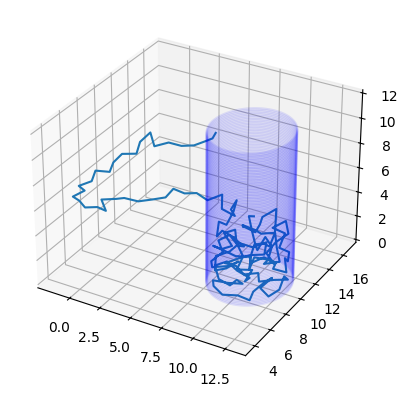

Iteration 1249


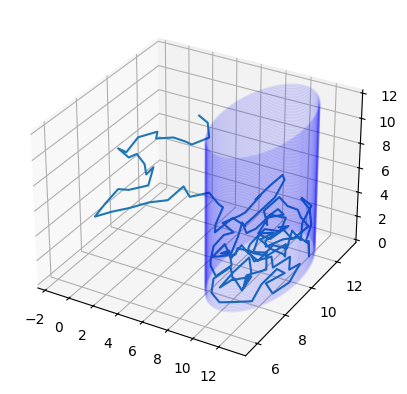

Iteration 1299


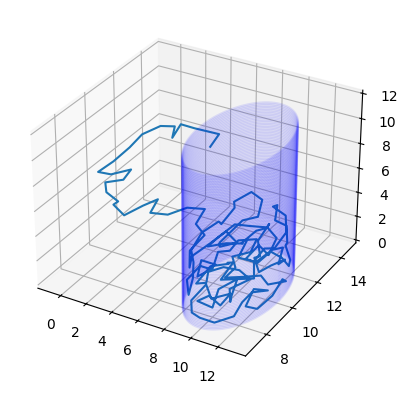

Iteration 1349


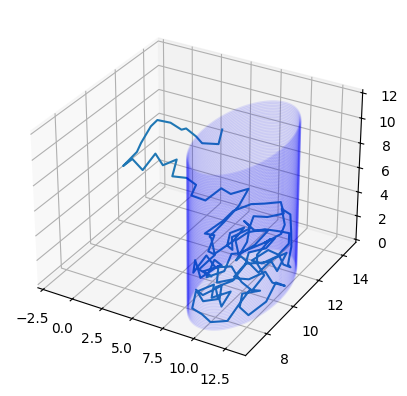

Iteration 1399


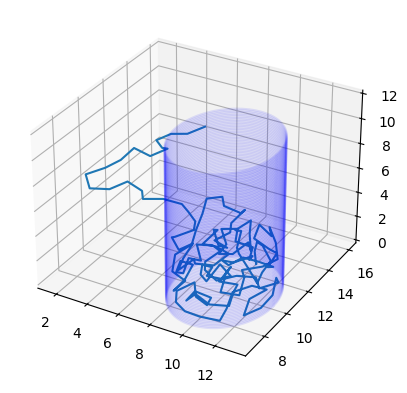

Iteration 1449


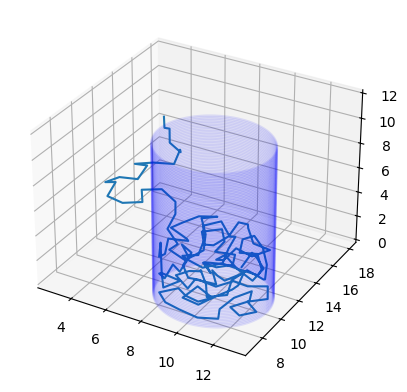

Iteration 1499


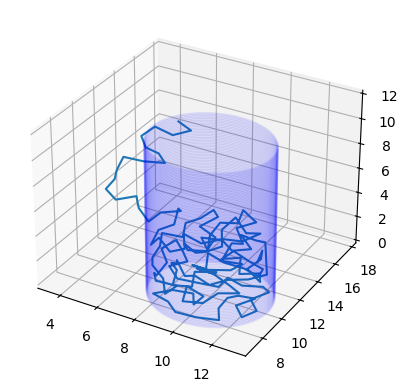

Iteration 1549


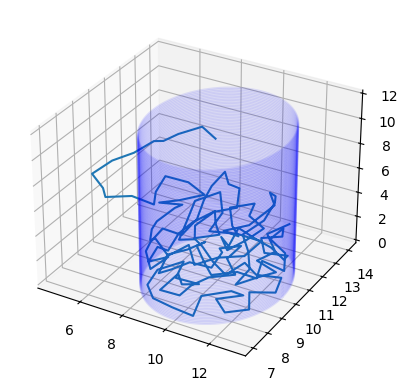

Iteration 1599


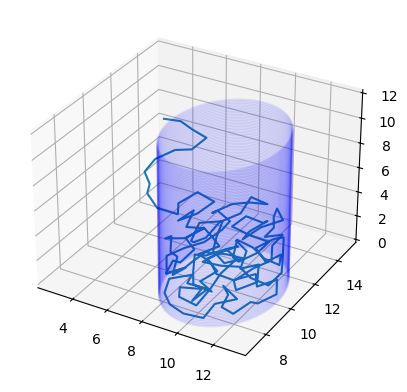

Iteration 1649


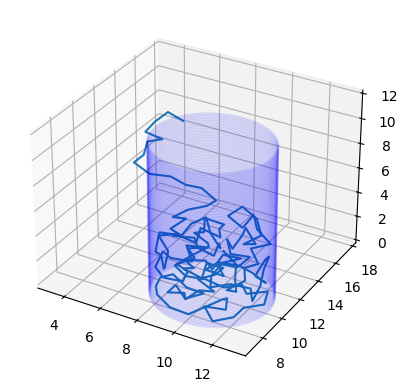

Iteration 1699


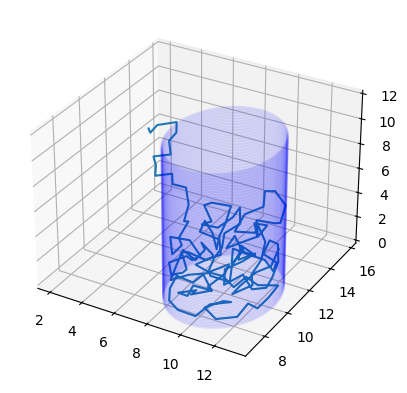

Iteration 1749


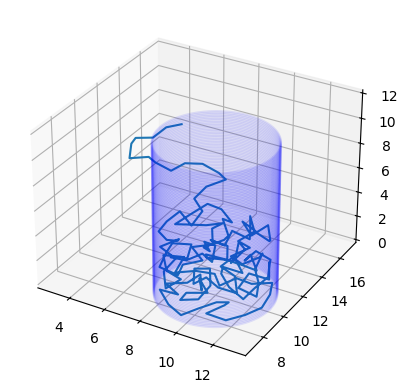

Iteration 1799


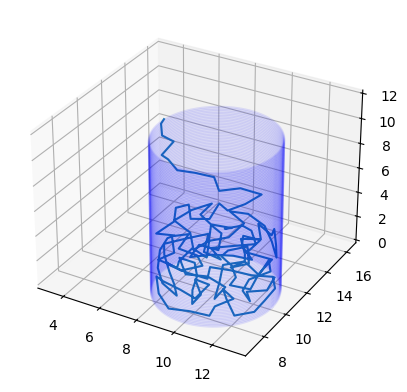

Iteration 1849


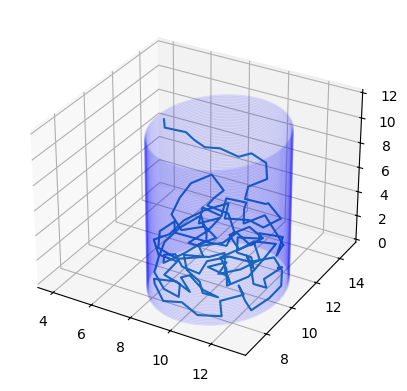

Iteration 1899


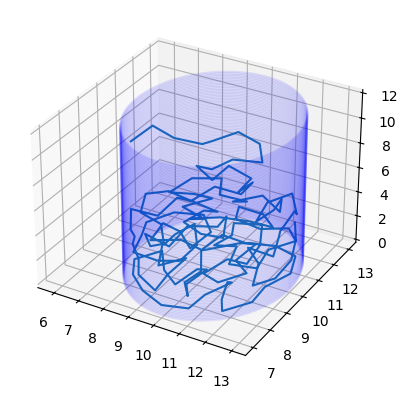

Iteration 1949


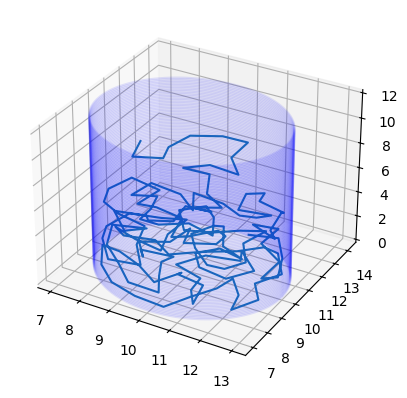

Iteration 1999


In [7]:
#visualize
intstep = 2000
skip = 50

sys_dt = 0.005
system.time_step = sys_dt
sys_temperature = 0.2
system.thermostat.set_langevin(kT = sys_temperature, gamma = sys_gamma, seed=20)

radius = 3
center = [10., 10., 0.]
height = 12
theta = np.linspace(0, 2*np.pi, 100)
z_values = np.linspace(0, height, 100)

def main():
    for i in range(intstep):
        #print(p)
        system.integrator.run(200)
        if i % skip == skip - 1:
            positions = []
            for particle in system.part:
                positions.append(particle.pos)
            positions = np.asarray(positions)

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2])
            for z in z_values:
                x_circle = center[0] + radius * np.cos(theta)
                y_circle = center[1] + radius * np.sin(theta)
                z_circle = z * np.ones_like(theta)
                ax.plot(x_circle, y_circle, z_circle, color='blue', alpha=0.1)
            plt.show()
            print(f"Iteration {i}")

        if i == 1000:
            #field = espressomd.constraints.HomogeneousFlowField(gamma=1, u=[0, 0, -0.5])
            #system.constraints.add(field)
            electric_field_strength = [0, 0, 0.5] 
            linear_electric_potential = espressomd.constraints.LinearElectricPotential(E=electric_field_strength, phi=0)
            system.constraints.add(linear_electric_potential)

system.time = 0
t = Thread(target=main)
t.daemon = True
t.start()

Iteration 49
Iteration 99
Iteration 149
Iteration 199
Iteration 249
Iteration 299
Iteration 349
Iteration 399
Iteration 449
Iteration 499
Iteration 549
Iteration 599
Iteration 649
Iteration 699
Iteration 749
Iteration 799
Iteration 849
Iteration 899
Iteration 949
Iteration 999
Iteration 1049
Iteration 1099
Iteration 1149
Iteration 1199
Iteration 1249
Iteration 1299
Iteration 1349
Iteration 1399
Iteration 1449
Iteration 1499
Iteration 1549
Iteration 1599
Iteration 1649
Iteration 1699
Iteration 1749
Iteration 1799
Iteration 1849
Iteration 1899
Iteration 1949
Iteration 1999


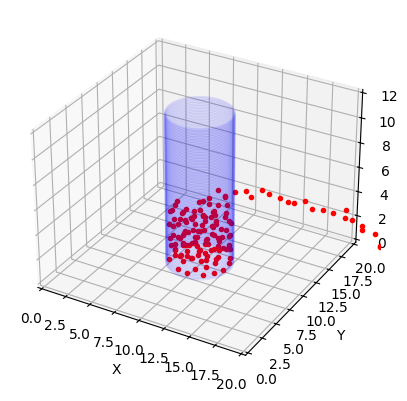

In [8]:
radius = 3
center = [10., 10., 0.]
height = 12
theta = np.linspace(0, 2*np.pi, 100)
z_values = np.linspace(0, height, 100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

all_positions = []

def update(frame):
    ax.clear()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 12)
    
    positions = all_positions[frame]
    ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2], 'r.')
    
    # plot cylinder
    for z in z_values:
        x_circle = center[0] + radius * np.cos(theta)
        y_circle = center[1] + radius * np.sin(theta)
        z_circle = z * np.ones_like(theta)
        ax.plot(x_circle, y_circle, z_circle, color='blue', alpha=0.1)
    
    return []

#visualize
intstep = 2000
skip = 50

sys_dt = 0.005
sys_temperature = 0.2

def main():
    for i in range(intstep):
        system.integrator.run(200)
        if i % skip == skip - 1:
            positions = []
            for particle in system.part:
                positions.append(particle.pos)
            positions = np.asarray(positions)
            all_positions.append(positions)
            print(f"Iteration {i}")

        if i == 1000:
            electric_field_strength = [0, 0, 0.5]  
            linear_electric_potential = espressomd.constraints.LinearElectricPotential(E=electric_field_strength, phi=0)
            system.constraints.add(linear_electric_potential)

system.time = 0
main()

# save animation
ani = FuncAnimation(fig, update, frames=len(all_positions), interval=50)
ani.save('particle_animation.mp4', writer='ffmpeg')

plt.show()